# Tutorial 4

Run the folloing code block only when you are on Google Colab. If you are on a local Jupyter environment, chance are your OpenCV version is high enough that you don't need to update.


If you are on Colab, you will need to re-run this block every time you start you runtime

In [ ]:
# !pip install opencv-contrib-python==4.4.0.44 #for Colab only or if you do not have OpenCV installed yet

In [1]:
#Import and configure
%matplotlib inline
import cv2
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 13.0)    #adjust plotted images size

# Degenerate Case of F-Matrix

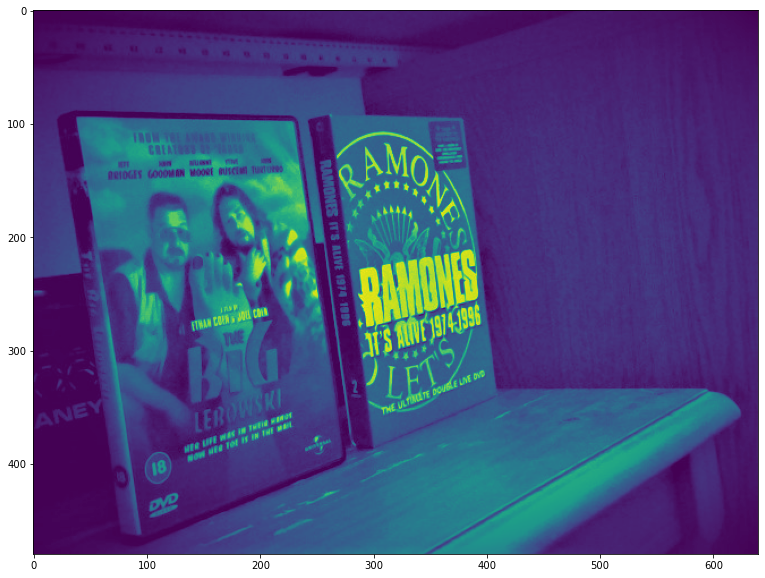

In [2]:
# Load images
img_left_dist = cv2.imread('F-matrix/image_l.jpg', 0)
img_right_dist = cv2.imread('F-matrix/image_r.jpg', 0)

plt.figure(figsize = (20, 10))
plt.imshow(img_left_dist)

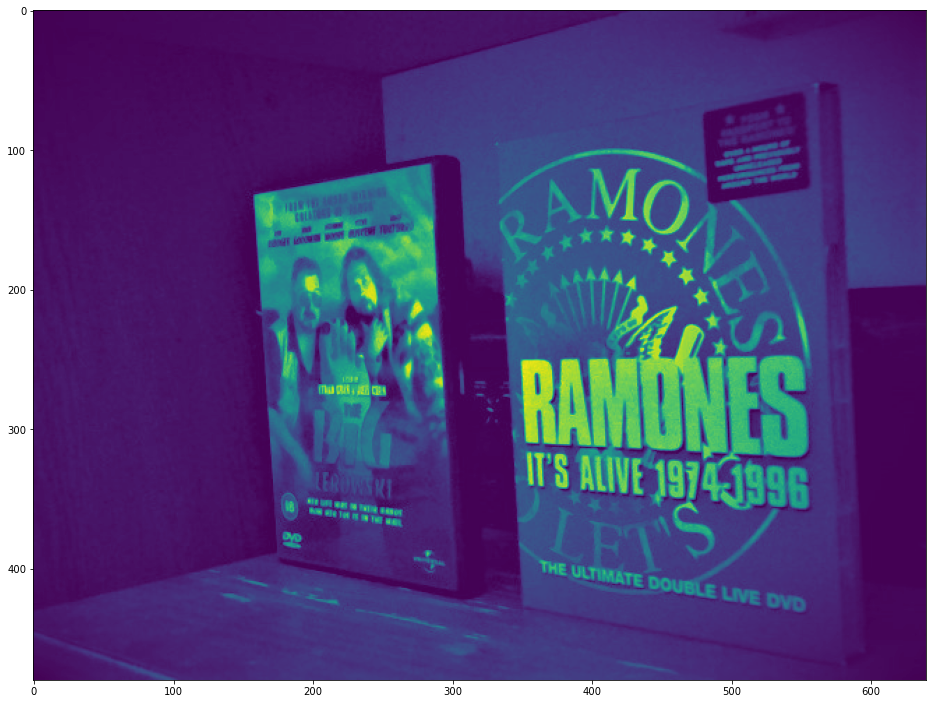

In [3]:
plt.imshow(img_right_dist)

## Undistortion

We need to distort the image first, because the algorithms used to estimate F-matrix assumes a perfect linear model of camera.

However, in this case since we don't have the camera matrix, and the photos look reasonably free of distortion, we will skip that for now.

## Feature Matching

Here we are using SIFT feature to match point of interest on two images. Technical details will be covered later in the class.

In [4]:
def feature_matching(img_left, img_right):
    '''
    Input:
    img_left - An image read by OpenCV's imread
    img_right - An image read by OpenCV's imread
    
    Output:
    points_left - array of tuples. Each tuple is a coordinate on the left image.
    points_right - array of tuples. Each tuple is a coordinate on the right image.
    '''
    # generate SIFT feature
    feature_detector = cv2.SIFT_create()
    keypoints_left, descriptors_left = feature_detector.detectAndCompute(img_left, None)
    keypoints_right, descriptors_right = feature_detector.detectAndCompute(img_right, None)

    # construct BFMatcher
    bf_matcher = cv2.BFMatcher()
    matches = bf_matcher.knnMatch(descriptors_left,descriptors_right, k=2)

    # apply ratio test
    good_matches = []
    for best, second in matches:
        if best.distance < 0.8*second.distance:
            # here we are converting it to a list to do visualization. 
            # I'm not sure why we need this but not doing so will make visualization fail
            good_matches.append([best]) 


    # convert OpenCV's special match class to regular array
    points_left = []
    points_right = []
    for best in good_matches:
        points_left.append(keypoints_left[best[0].queryIdx].pt)
        points_right.append(keypoints_right[best[0].trainIdx].pt)


    # some visualization
    img_matches = cv2.drawMatchesKnn(img_left, keypoints_left,
                                     img_right,keypoints_right,
                                     good_matches[:10],None,
                                     flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize = (20, 10))
    plt.imshow(img_matches);
    return points_left, points_right

### Undistorted Images

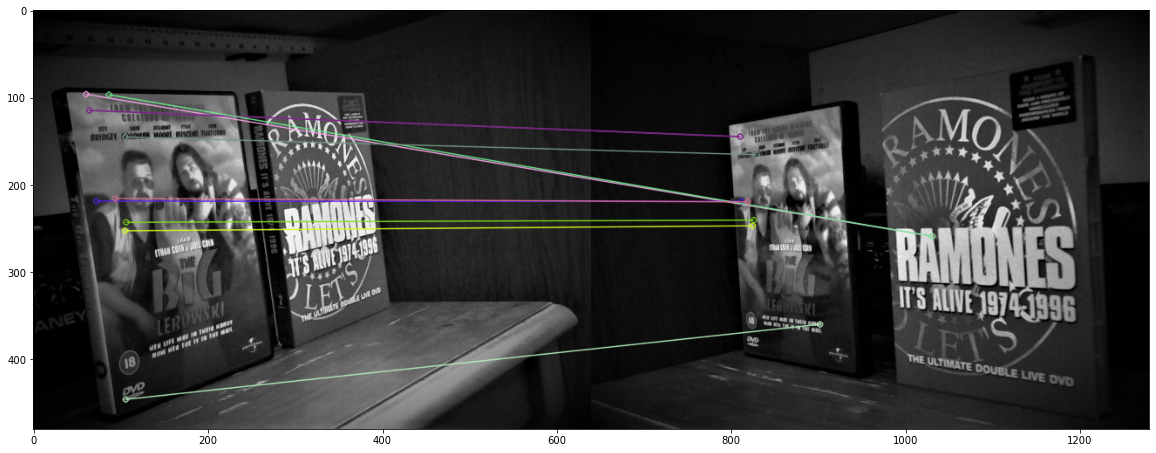

In [5]:
points_left_dist, points_right_dist = feature_matching(img_left_dist, img_right_dist)

## Estimating Fundamental Matrix

In [6]:
ptsLeft = np.int32(points_left_dist)
ptsRight = np.int32(points_right_dist)
F, mask = cv2.findFundamentalMat(ptsLeft,
                                 ptsRight,
                                 cv2.FM_LMEDS)
  
# We select only inlier points
ptsLeft_dis = ptsLeft[mask.ravel() == 1]
ptsRight_dis = ptsRight[mask.ravel() == 1]

## Plotting Epipolar Lines

In [7]:
def drawlines(img1, img2, lines, pts1, pts2):
    
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
      
    for r, pt1, pt2 in zip(lines, pts1[:60], pts2[:60]):
          
        color = tuple(np.random.randint(0, 255,
                                        3).tolist())
          
        x0, y0 = map(int, [0, -r[2] / r[1] ])
        x1, y1 = map(int, 
                     [c, -(r[2] + r[0] * c) / r[1] ])
          
        img1 = cv2.line(img1, 
                        (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1,
                          tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, 
                          tuple(pt2), 5, color, -1)
    return img1, img2

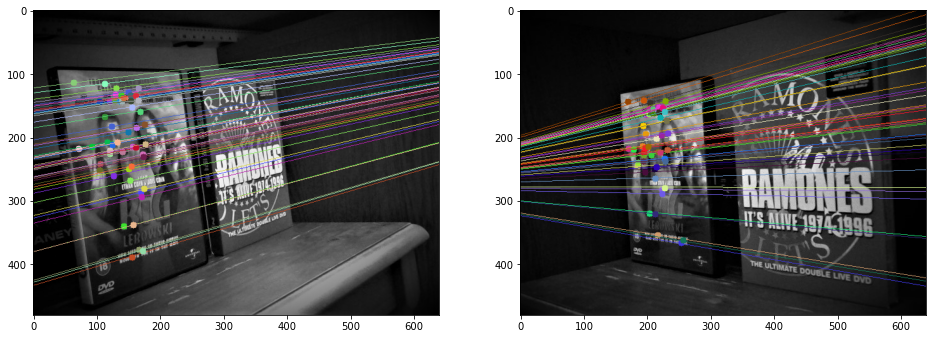

In [8]:
# Find epilines corresponding to points
# in right image (second image) and
# drawing its lines on left image
linesLeft = cv2.computeCorrespondEpilines(ptsRight_dis.reshape(-1,
                                                           1,
                                                           2),
                                          2, F)
linesLeft = linesLeft.reshape(-1, 3)
img5, img6 = drawlines(img_left_dist, img_right_dist, 
                       linesLeft, ptsLeft_dis,
                       ptsRight_dis)
   
# Find epilines corresponding to 
# points in left image (first image) and
# drawing its lines on right image
linesRight = cv2.computeCorrespondEpilines(ptsLeft_dis.reshape(-1, 1, 2), 
                                           1, F)
linesRight = linesRight.reshape(-1, 3)
  
img3, img4 = drawlines(img_right_dist, img_left_dist, 
                       linesRight, ptsRight_dis,
                       ptsLeft)
   
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

# RGB-D and 3D Reconstruction

<a id="cell2"></a>
## [Stereo Vision](#main)
In traditional stereo vision, two cameras, displaced horizontally from one another are used to obtain two differing views on a scene, in a manner similar to human binocular vision. By comparing these two images, the relative depth information can be obtained in the form of a disparity map, which encodes the difference in horizontal coordinates of corresponding image points. The values in this disparity map are inversely proportional to the scene depth at the corresponding pixel location.<p>
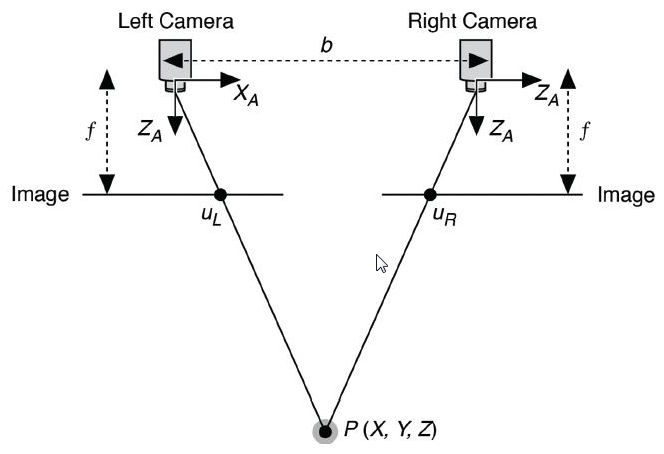

In a computer vision system, several pre-processing steps are required:
1. The image must first be undistorted, such that barrel distortion and tangential distortion are removed. This ensures that the observed image matches the projection of an ideal pinhole camera.
2. The image must be projected back to a common plane to allow comparison of the image pairs, known as image rectification.
3. An information measure which compares the two images is minimized. This gives the best estimate of the position of features in the two images, and creates a disparity map.
4. Optionally, the received disparity map is projected into a 3d point cloud. By utilising the cameras' projective parameters, the point cloud can be computed such that it provides measurements at a known scale.

The function between disparity $d$, focal length $f$, baseline $b$ and depth $z$ is:
$$d=\frac{f\cdot b}{z}\$$
We now show disparity map of this input:

<a id="sub1"></a>
### [Load image](#cell2)
You can download left and right images from [Middlebury stereo dataset](https://vision.middlebury.edu/stereo/data/), the images there has already been calibrated and finished image rectification. Here we use our own data to show how algorithm work.

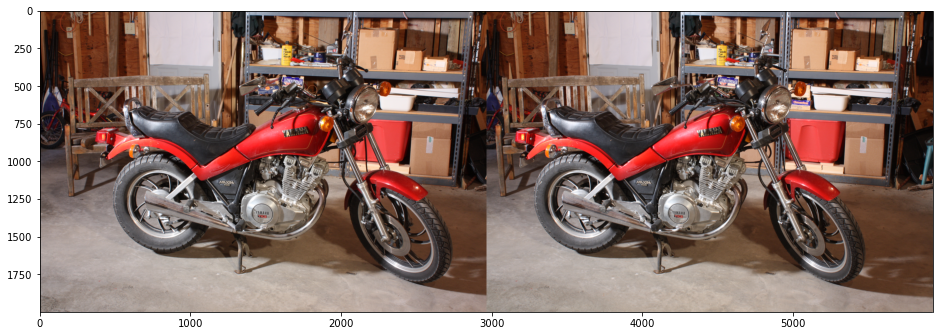

In [9]:
#read left and right images from folder

iml = cv2.imread('stereo/calibrated_source/motor/im0.png')
imr = cv2.imread('stereo/calibrated_source/motor/im1.png')
im=np.concatenate((iml,imr),1)
im= im[:,:,::-1]
plt.imshow(im)
plt.show()    #let's take a look at original images

<a id="sub11"></a>
### [Undistort images](#cell2)
First, we use camera matrix and distortion vector to undistort input images<p>

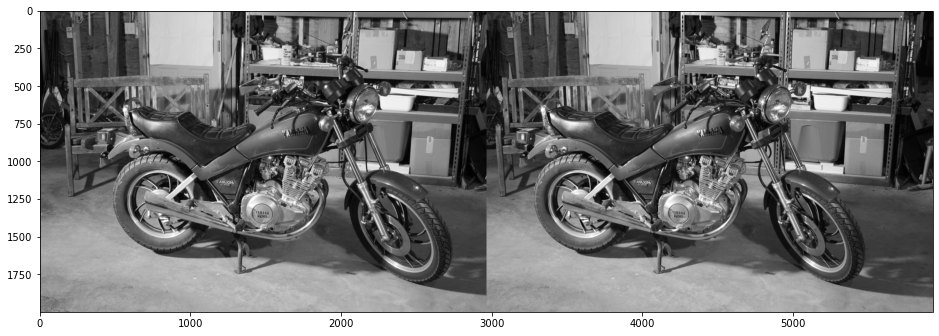

In [10]:
#define our camera intrinsic matrix
left_matrix=np.array([[3979.911,0,1244.772],
                     [0,3979.911,1019.507],
                     [0,0,1]])
right_matrix=np.array([[3979.911,0,1369.115],
                     [0,3979.911,1019.507],
                     [0,0,1]])
#define camera distortion
distortion=np.array([0.1123524,-0.14519944,0.00040207,0.00042764,0.])

iml_gray = cv2.cvtColor(iml,cv2.COLOR_BGR2GRAY)
imr_gray = cv2.cvtColor(imr,cv2.COLOR_BGR2GRAY)

#undistort two images
h,  w = iml_gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(left_matrix,distortion,(w,h),1,(w,h))
iml_gray_un = cv2.undistort(iml_gray, left_matrix, distortion, distortion, newcameramtx)
imr_gray_un = cv2.undistort(imr_gray, right_matrix, distortion, distortion, newcameramtx)
# crop the image
x,y,w,h = roi
iml_gray_un = iml_gray_un[y:y+h, x:x+w]
imr_gray_un= imr_gray_un[y:y+h, x:x+w]
im=np.concatenate((iml_gray,imr_gray),1)
plt.imshow(im,cmap="gray")
plt.show()

<a id="sub12"></a>
### [Image rectification](#cell2)
The image must be projected back to a common plane to allow comparison of the image pairs<p>
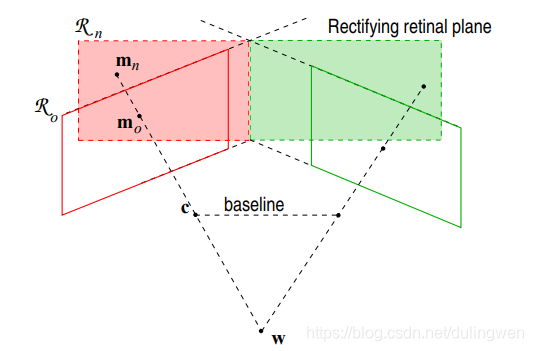

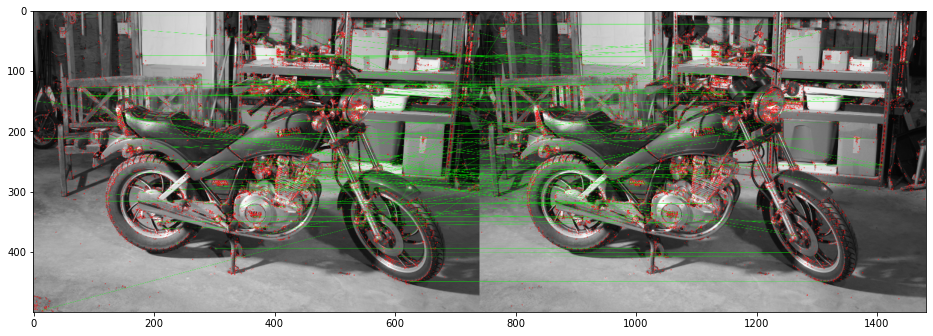

In [11]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(iml_gray, None)
kp2, des2 = sift.detectAndCompute(imr_gray, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Keep good matches: calculate distinctive image features
matchesMask = [[0, 0] for i in range(len(matches))]
good = []
pts1 = []
pts2 = []

for i, (m, n) in enumerate(matches):
    if m.distance < 0.3*n.distance:
        # Keep this keypoint pair
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=(255, 0, 0),
                   matchesMask=matchesMask[:1600],
                   flags=cv2.DrawMatchesFlags_DEFAULT)

keypoint_matches = cv2.drawMatchesKnn(
    iml_gray, kp1, imr_gray, kp2, random.choices(matches,k=1600), None, **draw_params)

n,m,_=keypoint_matches.shape
new=cv2.resize(keypoint_matches,(int(m/4),int(n/4)))
plt.imshow(new)
plt.show()

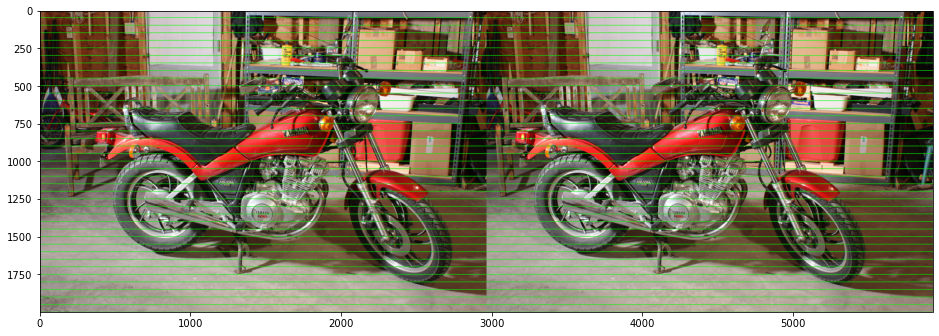

In [12]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
fundamental_matrix, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[inliers.ravel() == 1]
pts2 = pts2[inliers.ravel() == 1]


# Stereo rectification
h1, w1 = iml_gray.shape
h2, w2 = imr_gray.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), fundamental_matrix, imgSize=(w1, h1)
)

# Undistort (rectify) the images
c=np.linalg.norm((np.array(H1[:3,-1]).reshape(1,3),np.array(H2[:3,-1]).reshape(1,3)))
img1_rectified = cv2.warpPerspective(iml, H1, (w1, h1))
img2_rectified = cv2.warpPerspective(imr, H2, (w2, h2))

# image rectification check
def draw_line(image1, image2):
    height = max(image1.shape[0], image2.shape[0])
    width = image1.shape[1] + image2.shape[1]
    output = np.zeros((height, width, 3), dtype=np.uint8)
    output[0:image1.shape[0], 0:image1.shape[1]] = image1
    output[0:image2.shape[0], image1.shape[1]:] = image2
    # Draw equidistant parallel lines
    line_interval = 50  # interval：50
    for k in range(height // line_interval):
        cv2.line(output, (0, line_interval * (k + 1)), (2 * width, line_interval * (k + 1)), (0, 255, 0), thickness=2,
                 lineType=cv2.LINE_AA)
    return output

img1_rectified,img2_rectified=iml,imr # Our image has been already undistorted, so we use original images here
line = draw_line(img1_rectified, img2_rectified)
im= line[:,:,::-1]
plt.imshow(im)
plt.show()

<a id="sub3"></a>
### [Compute disparity map](#cell2)
We use opencv class <code><font color='red'>StereoSGBM_create</font></code> to compute disparity between two images. This class implements the modified [H. Hirschmuller algorithm](https://core.ac.uk/download/pdf/11134866.pdf) which you can learn more from [opencv documents](https://docs.opencv.org/master/d2/d85/classcv_1_1StereoSGBM.html).

In [13]:
# we define a pre-processing function to eliminate the effect of uneven light and some other factors
def preprocess(img1, img2):
    # color to gray
    if (img1.ndim == 3):
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    if (img2.ndim == 3):
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Histogram mean
    img1 = cv2.equalizeHist(img1)
    img2 = cv2.equalizeHist(img2)
    return img1, img2

In [14]:
# finding disparity
def stereoMatchSGBM(left_image, right_image, down_scale=False):
    # SGBM parameters setting
    if left_image.ndim == 2:
        img_channels = 1
    else:
        img_channels = 3
    blockSize = 3
    paraml = {'minDisparity': 0,
              'numDisparities': 128,
              'blockSize': blockSize,
              'P1': 8 * img_channels * blockSize ** 2,
              'P2': 64 * img_channels * blockSize ** 2,
              'disp12MaxDiff': 1,
              'preFilterCap': 63,
              'uniquenessRatio': 15,
              'speckleWindowSize': 100,
              'speckleRange': 1,
              'mode': cv2.STEREO_SGBM_MODE_SGBM_3WAY
              }

    # generate a SGBM object
    left_matcher = cv2.StereoSGBM_create(**paraml)
    paramr = paraml
    paramr['minDisparity'] = -paraml['numDisparities']
    right_matcher = cv2.StereoSGBM_create(**paramr)

    # computing disparity map
    size = (left_image.shape[1], left_image.shape[0])
    if down_scale == False:
        disparity_left = left_matcher.compute(left_image, right_image)
        disparity_right = right_matcher.compute(right_image, left_image)

    else:
        left_image_down = cv2.pyrDown(left_image)
        right_image_down = cv2.pyrDown(right_image)
        factor = left_image.shape[1] / left_image_down.shape[1]

        disparity_left_half = left_matcher.compute(left_image_down, right_image_down)
        disparity_right_half = right_matcher.compute(right_image_down, left_image_down)
        disparity_left = cv2.resize(disparity_left_half, size, interpolation=cv2.INTER_AREA)
        disparity_right = cv2.resize(disparity_right_half, size, interpolation=cv2.INTER_AREA)
        disparity_left = factor * disparity_left
        disparity_right = factor * disparity_right

    # real disparity
    trueDisp_left = disparity_left.astype(np.float32) / 16.
    trueDisp_right = disparity_right.astype(np.float32) / 16.

    return trueDisp_left, trueDisp_right

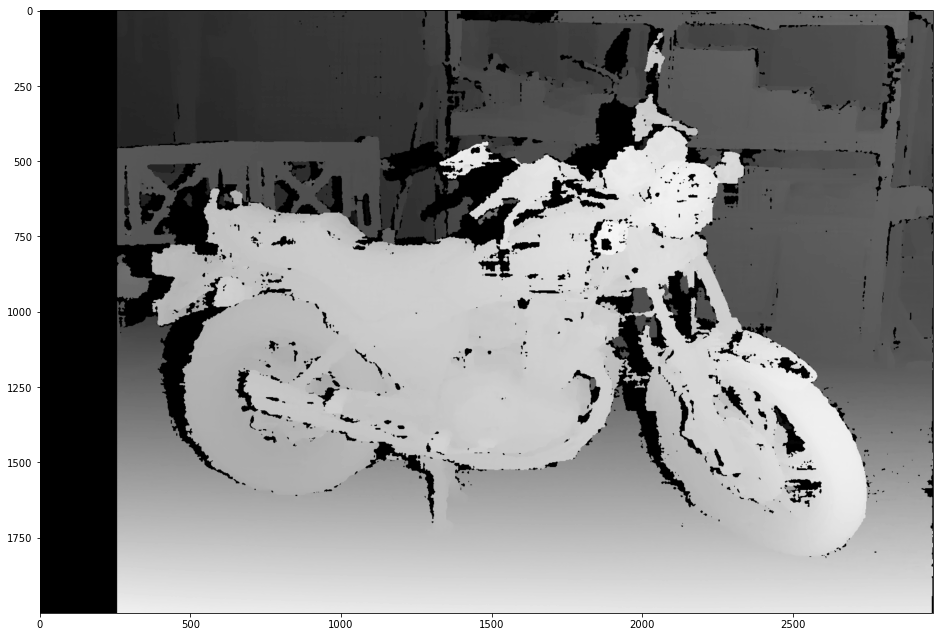

In [15]:
# show disparity map
iml_, imr_ = preprocess(img1_rectified, img2_rectified)
disp, _ = stereoMatchSGBM(iml_, imr_, True)
plt.imshow(disp,cmap="gray")
plt.show()

<a id="sub4"></a>
### [Recnstruct 3D point clouds](#cell2)
We use opencv function <code><font color='red'>ReprojectImageTo3D </font></code> to reconstruct point cloud by using disparity map and Q matrix which is a 4 x 4 perspective transformation matrix that can be obtained with opencv function <code><font color='red'>stereoRectify</font></code>. But here since our inpute image has already been calibrated. We can compute it by following function:
$$\begin{bmatrix} 1 & 0 & 0 & -c_x \\ 0 & 1 & 0 & -c_y \\ 0 & 0 & 0 & f \\0 & 0 & \frac{-1}{T_x} & \frac{c_x-c_{x}^{'}}{T_x}\end{bmatrix}$$
Where $c_x,c_y$ is the optical center (the principal point) of left camera, the focal length is $f$,  $c_{x}^{'}$ is the optical center (the principal point) of right camera and $T_x$ is negative baseline.

In [16]:
nb=-193.001
Q=np.array([[1,0,0,-left_matrix[0,2]],
           [0,1,0,-left_matrix[1,2]],
           [0,0,0,left_matrix[0,0]],
           [0,0,-1/nb,(left_matrix[0,2]-right_matrix[0,2])/nb]])

points_3d = cv2.reprojectImageTo3D(disp, Q)
def hw3ToN3(points):
    height, width = points.shape[0:2]
    points_1 = points[:, :, 0].reshape(height * width, 1)
    points_2 = points[:, :, 1].reshape(height * width, 1)
    points_3 = points[:, :, 2].reshape(height * width, 1)
    points_ = np.hstack((points_1, points_2, points_3))
    return points_

points = hw3ToN3(points_3d)
colors = np.asarray(hw3ToN3(img1_rectified[:,:,::-1])/255)
idx = np.random.randint(0, points.shape[0], 50000)
sampled_points = points[idx]
sampled_color = colors[idx]

We visualize the point cloud, which are down-sampled due to the sheer number of points.

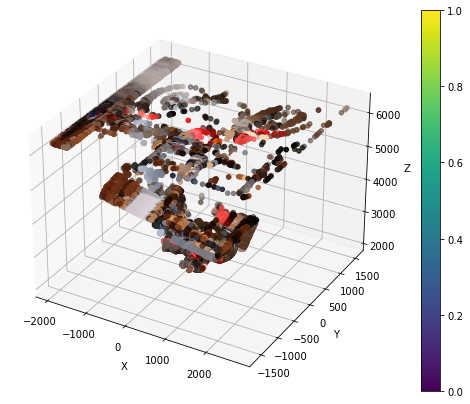

In [17]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(sampled_points[:,0], sampled_points[:,1], sampled_points[:,2], c = sampled_color)
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Try the folloing code block if you are on a local machine to have a better visualization of pointcloud. Run `pip install open3d` first in your terminal to install the required package.

In [ ]:
!pip install open3d

In [20]:
import open3d as o3d
cloud = o3d.geometry.PointCloud()    #create a point cloud

cloud.points = o3d.utility.Vector3dVector(hw3ToN3(points_3d))    #define point cloud coordinates
color=np.asarray(hw3ToN3(img1_rectified[:,:,::-1])/255)
cloud.colors = o3d.utility.Vector3dVector(color)    #define point cloud color
R = cloud.get_rotation_matrix_from_xyz((np.pi, 0, 0))    #rotate cloud to visualize
cloud.rotate(R, center=(0, 0, 0))
o3d.visualization.draw_geometries([cloud])

____
## Homework 

For this week's homework, try to reproduce the same task above, but with other images that you can find online. Please note that you will have to select the right images for the task, which you should already know how to based on the lecture and tutorial session.

> **Note**: For the homework, all you need to do is complete the following tasks and upload the necessary materials to the [HW4 Google Form](https://forms.gle/RjAEryze5jT5CDSq6).




**Tasks**
1. Repeat the task of estimating the Fundamental Matrix (F-Matrix) by using 2 other images that will result in a non-degenerate estimation. **Note**: You should be able to do so by reusing the same code, but with a different set of well-selected images instead.
    - Please provide the left and right images you have chosen to work with, together with the Epipolar lines drawn on for both images.
    - Please return your estimated Fundamental Matrix via screenshot as well.
    
2. Repeat the task of stereo depth estimation via the disparity map as seen above. You should use another set of images instead for your attempt. You are free to use any other images you can find or capture, but one easy source would be the https://vision.middlebury.edu/stereo/data/ seen above.
    - Please provide the raw images you have chosen to work with. Just like the previous task, provide both the left and right images.
    - Please provide the generated disparity map as well in the form of a screenshot of your plot. It is expected that your disparity map should approximately correspond to what we expect for the depth based on the given raw images above (e.g. by visual inspection). 